## Import Packages

In [1]:
import torch
import suit
import numpy as np
import matplotlib.pyplot as plt

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms as pth_transforms
from skimage.segmentation import mark_boundaries
from timm.models import create_model
from fast_slic.avx2 import SlicAvx2
from PIL import Image


/home/shjang/anaconda3/envs/suit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Arguments

In [2]:
INPUT_SIZE = (224, 224)
N_SEGMENTS = 196
MODEL_NAME = "suit_base_dino"
SAMPLE_PATH = "assets/ILSVRC2012_val_00026736.JPEG"

## Load Checkpoint

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = create_model(MODEL_NAME, pretrained=True)

for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to(device)

suit_base_dino.pth not found. Downloading from https://drive.google.com/uc?export=download&id=1jnr9WLEzyrv4AzKWT0U04PS6CBO9v0IH...


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1jnr9WLEzyrv4AzKWT0U04PS6CBO9v0IH
From (redirected): https://drive.google.com/uc?export=download&id=1jnr9WLEzyrv4AzKWT0U04PS6CBO9v0IH&confirm=t&uuid=9755d505-3edf-48b8-ad81-92b391f06e63
To: /home/shjang/workspace/SuiT/suit_base_dino.pth
100%|██████████| 437M/437M [00:35<00:00, 12.2MB/s] 


SuperpixelVisionTransformer(
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): EmptyMaskingBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EmptyMaskingAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): 

## Plot Sample Image

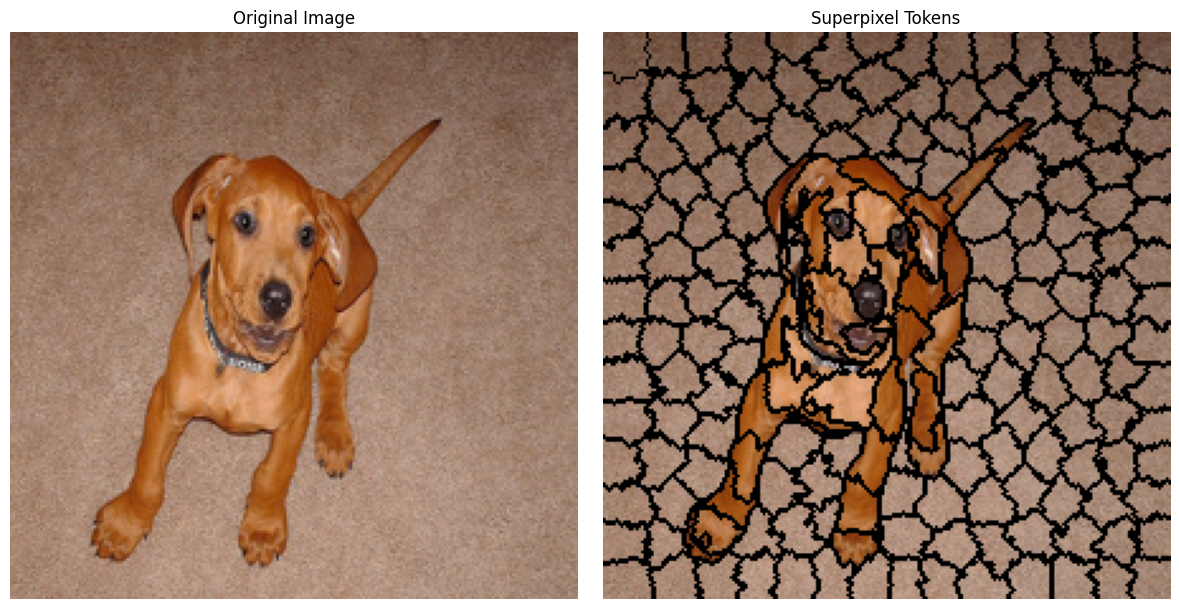

In [4]:
transform = pth_transforms.Compose([
            pth_transforms.Resize(INPUT_SIZE),
            pth_transforms.ToTensor(),
            pth_transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])

with open(SAMPLE_PATH, 'rb') as f:
    img = Image.open(f).convert('RGB')

# get superpixel assignment
image_for_spix = img.resize(INPUT_SIZE)
image_for_spix = np.array(image_for_spix, dtype=np.uint8) * 255
slic_ = SlicAvx2(num_components=N_SEGMENTS, compactness=10)
assignment = slic_.iterate(image_for_spix)
assignment = torch.tensor(assignment).unsqueeze(0).unsqueeze(0) # (b, c, h, w)


# plot sample image
original_image = np.array(img.resize(INPUT_SIZE))
spix_image = mark_boundaries(original_image, assignment.numpy().squeeze(), mode='inner',color=(0, 0, 0))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(spix_image)
axes[1].set_title("Superpixel Tokens")
axes[1].axis('off')
plt.tight_layout()
plt.show()

img = transform(img).unsqueeze(0) # for model forward

## Get Last Self-Attention

In [5]:
img, assignment = img.to(device), assignment.to(device)
attention = model.get_last_selfattention(img, assignment) # (b, n_head, n_tokens, n_tokens)

In [6]:
attention = attention[0, :, 0, 1:].mean(0) # (n_tokens-1)
assignment = assignment.squeeze(0).squeeze(0).long() # (h, w)
new_map = attention[assignment]
new_map = new_map.cpu().numpy()

## Attention Map Visualization

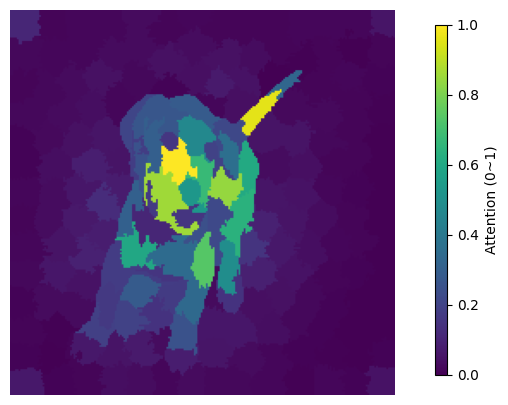

In [7]:
min_val = new_map.min().item()
max_val = new_map.max().item()

new_map_norm = (new_map - min_val) / (max_val - min_val)  # (h, w), [0,1] normalize

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

im = axes.imshow(new_map_norm, cmap='viridis', vmin=0.0, vmax=1.0)
axes.axis('off') 

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Attention (0~1)")

plt.show()

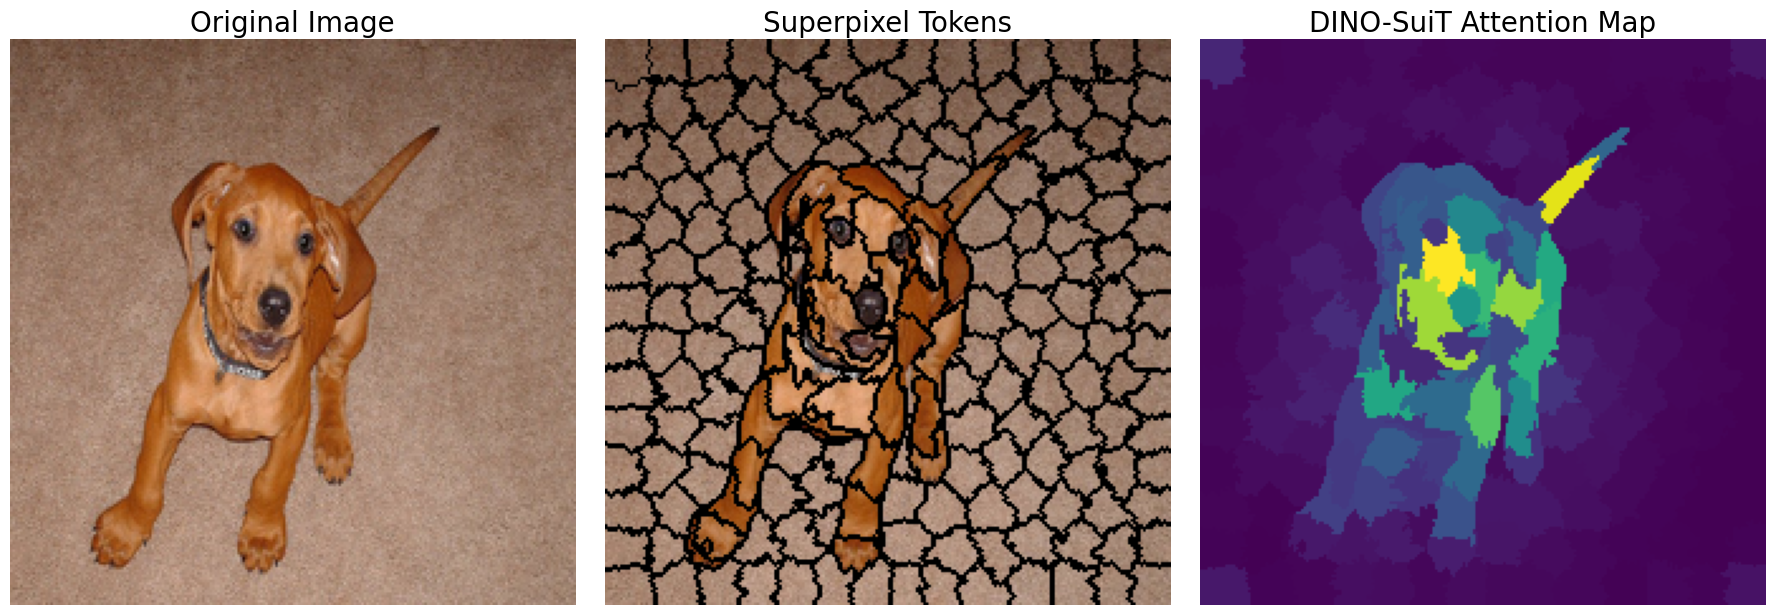

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original_image)
axes[0].set_title("Original Image", fontsize=20)
axes[0].axis('off')
axes[1].imshow(spix_image)
axes[1].set_title("Superpixel Tokens", fontsize=20)
axes[1].axis('off')
axes[2].imshow(new_map_norm, cmap='viridis', vmin=0.0, vmax=1.0)
axes[2].set_title("DINO-SuiT Attention Map", fontsize=20)
axes[2].axis('off')
plt.tight_layout()
plt.show()
